In [1]:
import json
import numpy as np
import glob
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from matplotlib.colors import ListedColormap
from matplotlib import rc
import random

In [2]:
# matplotlib 한글 폰트 깨짐 문제 해결
import matplotlib.font_manager as fm
font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc'
fontprop = fm.FontProperties(fname=font_path)

In [4]:
# 경로 설정

data_path = '/workspace/Data_All/'

img_path = data_path + 'image/'                     # /workspace/Data_All/image/
json_path = data_path + 'label/'                    # /workspace/Data_All/label/
segment_path = data_path + 'segmentation/'          # /workspace/Data_All/segmentation/

panic_img_path = img_path + 'panic'                 # /workspace/Data_All/image/panic/

In [ ]:
# 라벨 정보 json 파일 (train, val, test 파일 통합)
# train_panic.json + val_panic.json + test_panic.json -> json_panic

# json 파일 각각 불러오기
with open (json_path + "train_panic.json", "r", encoding='euc-kr') as f:
    json_panic_train = json.load(f)
with open (json_path + "val_panic.json", "r", encoding='euc-kr') as f:
    json_panic_val = json.load(f)
with open (json_path + "test_panic.json", "r", encoding='euc-kr') as f:
    json_panic_test = json.load(f)

# 하나의 파일로 통합
json_panic = []
if isinstance(json_panic_train, list):
    json_panic.extend(json_panic_train)
if isinstance(json_panic_val, list):
    json_panic.extend(json_panic_val)
if isinstance(json_panic_test, list):
    json_panic.extend(json_panic_test)

In [7]:
len(json_panic)     # 1500(train) + 300(val) + 300(test) = 2100

2100

In [8]:
# 이미지와 json 파일 내 이름이 일치하는지 확인

IMAGE_EXTENSIONS = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp'}

# 폴더 내 이미지 파일 개수 세기
def count_images_in_folder(folder_path):
    image_count = 0
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if os.path.splitext(file)[1].lower() in IMAGE_EXTENSIONS:
                image_count += 1
    return image_count

image_count = count_images_in_folder(panic_img_path)
print(f"폴더 내 이미지 파일 개수: {image_count}")
print(f"json 파일 길이 : {len(json_panic)}")
print()

# 폴더 내 이미지 파일 이름 수집
def get_image_files_in_folder(folder_path):
    image_files = set()
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if os.path.splitext(file)[1].lower() in IMAGE_EXTENSIONS:
                image_files.add(file)
    return image_files

# JSON 파일 내 이미지 파일 이름 수집
def get_image_files_in_json(json_file):
    json_filenames = {entry["filename"] for entry in json_file}
    return json_filenames

# 비교 수행
image_files_in_folder = get_image_files_in_folder(panic_img_path)
image_files_in_json = get_image_files_in_json(json_panic)

# 누락된 파일 찾기
missing_in_json = image_files_in_folder - image_files_in_json
missing_in_folder = image_files_in_json - image_files_in_folder

# 결과 출력 
print(f"JSON 파일에 없는 폴더 내 이미지 파일: {missing_in_json}")
print(f"폴더에 없는 JSON 파일의 이미지 파일: {missing_in_folder}")

폴더 내 이미지 파일 개수: 2100
json 파일 길이 : 2100

JSON 파일에 없는 폴더 내 이미지 파일: set()
폴더에 없는 JSON 파일의 이미지 파일: set()


In [9]:
json_panic[0]

{'filename': 'twdva8d723865fa1005873a6967797c75f3dd83197f13f7daa3e3926947071al6.jpg',
 'gender': '여',
 'age': 20,
 'isProf': '일반인',
 'faceExp_uploader': '당황',
 'bg_uploader': '상업시설/점포/시장',
 'annot_A': {'boxes': {'maxX': 2289.351,
   'maxY': 1162.7544,
   'minX': 1471.1471,
   'minY': 213.07580000000002},
  'faceExp': '중립',
  'bg': '상업시설/점포/시장'},
 'annot_B': {'boxes': {'maxX': 2280.8636809336676,
   'maxY': 1144.8658917460868,
   'minX': 1523.7319800419439,
   'minY': 142.7691863026925},
  'faceExp': '당황',
  'bg': '상업시설/점포/시장'},
 'annot_C': {'boxes': {'maxX': 2289.351,
   'maxY': 1162.7544000000003,
   'minX': 1471.1471,
   'minY': 213.07580000000002},
  'faceExp': '당황',
  'bg': '상업시설/점포/시장'}}

In [10]:
# Json 파일 -> DataFrame 변환
# df_panic

# 데이터 변환 함수 정의
def process_data(data):
    processed_data = []
    for item in data:
        base_info = {
            'filename': item.get('filename'),
            'gender': item.get('gender'),
            'age': item.get('age'),
            'isProf': item.get('isProf'),
            'faceExp_uploader': item.get('faceExp_uploader'),
            'bg_uploader': item.get('bg_uploader'),
        }

        # annot_A, annot_B, annot_C 데이터 추가
        for annot_key in ['annot_A', 'annot_B', 'annot_C']:
            annot = item.get(annot_key, {})
            row = {
                **base_info,
                'annot': annot_key,
                'faceExp': annot.get('faceExp'),
                'bg': annot.get('bg'),
                'minX': annot.get('boxes', {}).get('minX'),
                'minY': annot.get('boxes', {}).get('minY'),
                'maxX': annot.get('boxes', {}).get('maxX'),
                'maxY': annot.get('boxes', {}).get('maxY'),
            }
            processed_data.append(row)
    return pd.DataFrame(processed_data)

# 데이터프레임 생성
df_panic = process_data(json_panic)

In [11]:
df_panic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6300 entries, 0 to 6299
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   filename          6300 non-null   object 
 1   gender            6300 non-null   object 
 2   age               6300 non-null   int64  
 3   isProf            6300 non-null   object 
 4   faceExp_uploader  6300 non-null   object 
 5   bg_uploader       6300 non-null   object 
 6   annot             6300 non-null   object 
 7   faceExp           6300 non-null   object 
 8   bg                6300 non-null   object 
 9   minX              6300 non-null   float64
 10  minY              6300 non-null   float64
 11  maxX              6300 non-null   float64
 12  maxY              6300 non-null   float64
dtypes: float64(4), int64(1), object(8)
memory usage: 640.0+ KB


In [12]:
df_panic

filename gender  age isProf  \
0     twdva8d723865fa1005873a6967797c75f3dd83197f13f...      여   20    일반인   
1     twdva8d723865fa1005873a6967797c75f3dd83197f13f...      여   20    일반인   
2     twdva8d723865fa1005873a6967797c75f3dd83197f13f...      여   20    일반인   
3     tfcq8e7c42da5f56ce61f3ef372a3fe8339f4670407966...      남   30    전문인   
4     tfcq8e7c42da5f56ce61f3ef372a3fe8339f4670407966...      남   30    전문인   
...                                                 ...    ...  ...    ...   
6295  5wda5e3c4319affe6513f2523601db44e653746b545af1...      여   20    전문인   
6296  5wda5e3c4319affe6513f2523601db44e653746b545af1...      여   20    전문인   
6297  xarc78a73341474a83a33b3448c8d1334c8ef30f407d45...      여   30    일반인   
6298  xarc78a73341474a83a33b3448c8d1334c8ef30f407d45...      여   30    일반인   
6299  xarc78a73341474a83a33b3448c8d1334c8ef30f407d45...      여   30    일반인   

     faceExp_uploader        bg_uploader    annot faceExp                 bg  \
0                  당황         상업시설/점포/시장  annot_A      중립         상업시설/점포/시장   
1                  당황         상업시설/점포/시장  annot_B      당황         상업시설/점포/시장   
2                  당황         상업시설/점포/시장  annot_C      당황         상업시설/점포/시장   
3                  당황              도심 환경  annot_A      당황            실외 자연환경   
4                  당황              도심 환경  annot_B      중립              도심 환경   
...               ...                ...      ...     ...                ...   
6295               당황      스포츠 관람 및 레저시설  annot_B      불안            오락/공연시설   
6296               당황      스포츠 관람 및 레저시설  annot_C      기쁨         상업시설/점포/시장   
6297               당황  교통/이동수단(엘리베이터 포함)  annot_A      중립              도심 환경   
6298               당황  교통/이동수단(엘리베이터 포함)  annot_B      불안  교통/이동수단(엘리베이터 포함)   
6299               당황  교통/이동수단(엘리베이터 포함)  annot_C      불안  교통/이동수단(엘리베이터 포함)   

             minX        minY         maxX         maxY  
0     1471.147100  213.075800  2289.351000  1162.754400  
1     1523.731980  142.769186  2280.863681  1144.865892  
2     1471.147100  213.075800  2289.351000  1162.754400  
3     1147.099757  219.311950  2129.559344  1594.946500  
4     1156.344622  364.474895  2101.320494  1598.860145  
...           ...         ...          ...          ...  
6295   369.507300  204.344300   869.937900   878.133800  
6296   396.049602  204.344300   843.395598   878.133800  
6297   179.734120  435.413970  1055.582200  1599.491800  
6298   179.698293  415.521034  1047.660110  1579.598864  
6299   186.893332  452.796781  1036.470796  1601.126761  

[6300 rows x 13 columns]

##### 표정 데이터 확인
- faceExp_uploader (image) 와 faceExp (annot) 차이 확인
- 표정 정보가 다른 이미지들 어떻게 처리할지

In [13]:
df_panic['faceExp_uploader'].value_counts()


faceExp_uploader
당황    6300
Name: count, dtype: int64

In [14]:
df_panic['faceExp'].value_counts()

faceExp
당황    4420
불안     596
중립     364
상처     312
기쁨     256
분노     217
슬픔     135
Name: count, dtype: int64

In [18]:
# faceExp가 당황이 아닌 데이터 추출
def process_non_panic_data(data):
    processed_data = []
    for item in data:
        base_info = {
            'filename': item.get('filename'),
            'gender': item.get('gender'),
            'age': item.get('age'),
            'isProf': item.get('isProf'),
            'faceExp_uploader': item.get('faceExp_uploader'),
            'bg_uploader': item.get('bg_uploader'),
        }

        # Process each annotation and filter for non-panic faceExp
        for annot_key in ['annot_A', 'annot_B', 'annot_C']:
            annot = item.get(annot_key, {})
            face_exp = annot.get('faceExp')
            if face_exp != "당황":  # Only include non-panic faceExp
                row = {
                    **base_info,
                    'annot': annot_key,
                    'faceExp': face_exp,
                    'bg': annot.get('bg'),
                    'minX': annot.get('boxes', {}).get('minX'),
                    'minY': annot.get('boxes', {}).get('minY'),
                    'maxX': annot.get('boxes', {}).get('maxX'),
                    'maxY': annot.get('boxes', {}).get('maxY'),
                }
                processed_data.append(row)
    return pd.DataFrame(processed_data)

df_not_panic = process_non_panic_data(json_panic)

In [19]:
df_not_panic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1880 entries, 0 to 1879
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   filename          1880 non-null   object 
 1   gender            1880 non-null   object 
 2   age               1880 non-null   int64  
 3   isProf            1880 non-null   object 
 4   faceExp_uploader  1880 non-null   object 
 5   bg_uploader       1880 non-null   object 
 6   annot             1880 non-null   object 
 7   faceExp           1880 non-null   object 
 8   bg                1880 non-null   object 
 9   minX              1880 non-null   float64
 10  minY              1880 non-null   float64
 11  maxX              1880 non-null   float64
 12  maxY              1880 non-null   float64
dtypes: float64(4), int64(1), object(8)
memory usage: 191.1+ KB


In [ ]:
df_not_panic

filename gender  age isProf  \
0     twdva8d723865fa1005873a6967797c75f3dd83197f13f...      여   20    일반인   
1     tfcq8e7c42da5f56ce61f3ef372a3fe8339f4670407966...      남   30    전문인   
2     tfcq8e7c42da5f56ce61f3ef372a3fe8339f4670407966...      남   30    전문인   
3     1x46281aba4fc588baac2be45c9ef57caaa788a14aa2bc...      여   20    전문인   
4     1x46281aba4fc588baac2be45c9ef57caaa788a14aa2bc...      여   20    전문인   
...                                                 ...    ...  ...    ...   
1875  5wda5e3c4319affe6513f2523601db44e653746b545af1...      여   20    전문인   
1876  5wda5e3c4319affe6513f2523601db44e653746b545af1...      여   20    전문인   
1877  xarc78a73341474a83a33b3448c8d1334c8ef30f407d45...      여   30    일반인   
1878  xarc78a73341474a83a33b3448c8d1334c8ef30f407d45...      여   30    일반인   
1879  xarc78a73341474a83a33b3448c8d1334c8ef30f407d45...      여   30    일반인   

     faceExp_uploader        bg_uploader    annot faceExp                 bg  \
0                  당황         상업시설/점포/시장  annot_A      중립         상업시설/점포/시장   
1                  당황              도심 환경  annot_B      중립              도심 환경   
2                  당황              도심 환경  annot_C      중립              도심 환경   
3                  당황         상업시설/점포/시장  annot_B      불안         상업시설/점포/시장   
4                  당황         상업시설/점포/시장  annot_C      불안         상업시설/점포/시장   
...               ...                ...      ...     ...                ...   
1875               당황      스포츠 관람 및 레저시설  annot_B      불안            오락/공연시설   
1876               당황      스포츠 관람 및 레저시설  annot_C      기쁨         상업시설/점포/시장   
1877               당황  교통/이동수단(엘리베이터 포함)  annot_A      중립              도심 환경   
1878               당황  교통/이동수단(엘리베이터 포함)  annot_B      불안  교통/이동수단(엘리베이터 포함)   
1879               당황  교통/이동수단(엘리베이터 포함)  annot_C      불안  교통/이동수단(엘리베이터 포함)   

             minX        minY         maxX         maxY  
0     1471.147100  213.075800  2289.351000  1162.754400  
1     1156.344622  364.474895  2101.320494  1598.860145  
2     1106.302407  251.019522  2132.298807  1626.654072  
3     1122.588426  654.313748  1793.116429  1536.142498  
4     1120.573320  649.473483  1793.209047  1545.485191  
...           ...         ...          ...          ...  
1875   369.507300  204.344300   869.937900   878.133800  
1876   396.049602  204.344300   843.395598   878.133800  
1877   179.734120  435.413970  1055.582200  1599.491800  
1878   179.698293  415.521034  1047.660110  1579.598864  
1879   186.893332  452.796781  1036.470796  1601.126761  

[1880 rows x 13 columns]

In [21]:
df_not_panic['faceExp'].value_counts()

faceExp
불안    596
중립    364
상처    312
기쁨    256
분노    217
슬픔    135
Name: count, dtype: int64

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


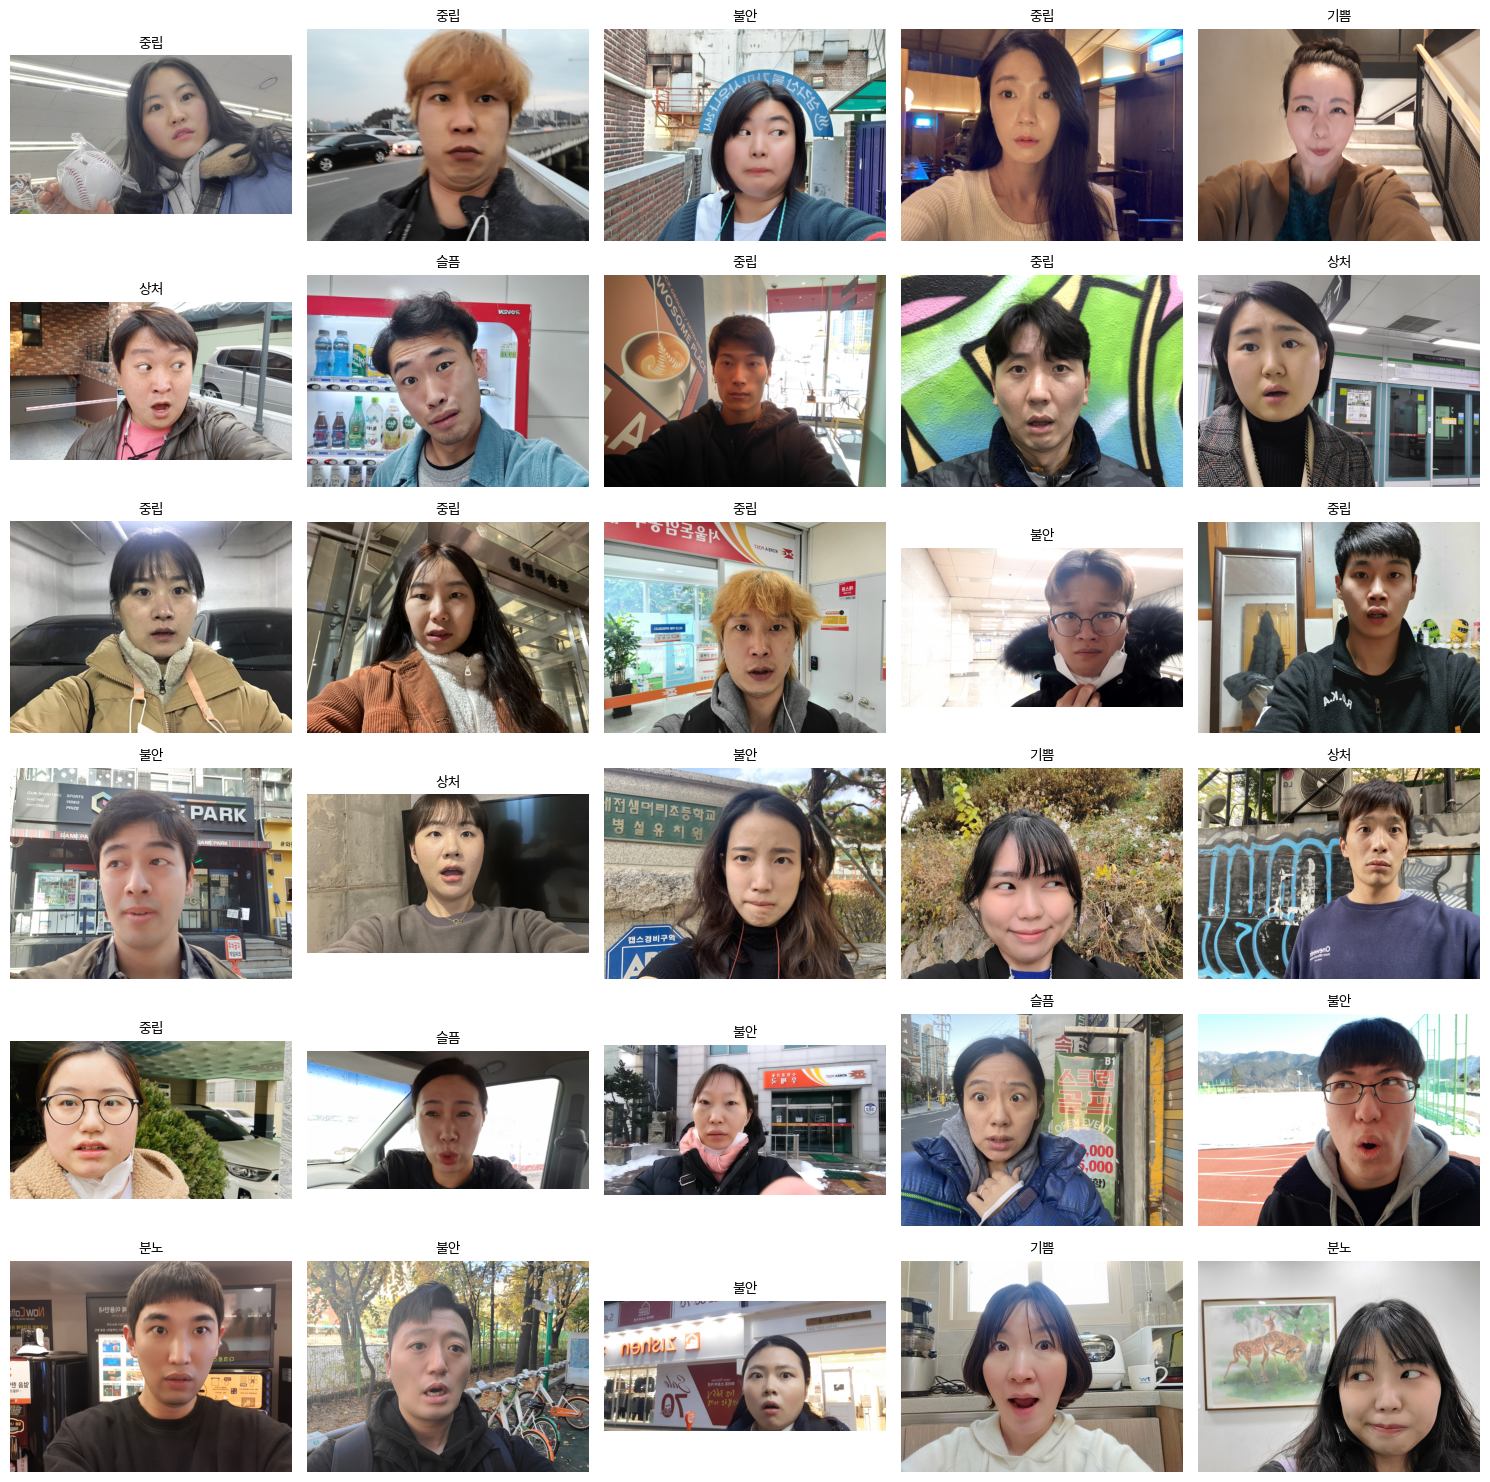

In [22]:
# 감정 정보가 다른 이미지 시각화
unique_filenames = df_not_panic['filename'].unique()

plt.figure(figsize=(15, 15))

for i, filename in enumerate(unique_filenames):
    if i >= 30:  # Show only the first 30 images for this example
        break
    image_path = os.path.join(panic_img_path, filename)
    if os.path.exists(image_path):  # Ensure the file exists
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.subplot(6, 5, i + 1)
        plt.imshow(image)
        faceExp = df_not_panic[df_not_panic['filename'] == filename]['faceExp'].iloc[0]
        plt.title(faceExp, fontproperties=fontprop)
        plt.axis('off')

plt.tight_layout()
plt.show()

##### 연령, 성별, 전문인 column 분포 확인

In [23]:
# 연령 분포 확인
df_panic['age'].value_counts(), df_panic['age'].value_counts(normalize=True)

(age
 20    3201
 30    2118
 40     750
 50     171
 10      60
 Name: count, dtype: int64,
 age
 20    0.508095
 30    0.336190
 40    0.119048
 50    0.027143
 10    0.009524
 Name: proportion, dtype: float64)

In [24]:
# 성별 분포 확인
df_panic['gender'].value_counts(), df_panic['gender'].value_counts(normalize=True)

(gender
 여    3381
 남    2919
 Name: count, dtype: int64,
 gender
 여    0.536667
 남    0.463333
 Name: proportion, dtype: float64)

In [ ]:
# 전문인 여부
df_panic['isProf'].value_counts(), df_panic['isProf'].value_counts(normalize=True)

(isProf
 일반인    3270
 전문인    3030
 Name: count, dtype: int64,
 isProf
 일반인    0.519048
 전문인    0.480952
 Name: proportion, dtype: float64)

##### 배경 정보 확인
- bg_uploader와 bg 차이 확인
- 배경 정보가 다른 이미지들 어떻게 처리할지

In [26]:
# 배경 정보
df_panic['bg_uploader'].value_counts(), df_panic['bg'].value_counts()

(bg_uploader
 숙박 및 거주공간            1173
 상업시설/점포/시장           1005
 도심 환경                 834
 공공시설/종교/의료시설          744
 실외 자연환경               642
 교통/이동수단(엘리베이터 포함)     639
 오락/공연시설               378
 문화재 및 유적지             312
 행사/사무공간               300
 스포츠 관람 및 레저시설         273
 Name: count, dtype: int64,
 bg
 숙박 및 거주공간            1195
 상업시설/점포/시장           1090
 공공시설/종교/의료            947
 도심 환경                 797
 실외 자연환경               630
 교통/이동수단(엘리베이터 포함)     530
 행사/사무공간               372
 오락/공연시설               356
 스포츠 관람 및 레저시설         202
 문화재 및 유적지             151
 공공시설/종교/의료시설           30
 Name: count, dtype: int64)

##### 박스 좌표 정보 확인
- 한 이미지 내 박스 좌표가 유사한지 시각화 및 좌표 수치 확인

In [28]:
# 박스 A,B,C의 좌표 차이가 일정 수치 이상인 데이터 검출

# 차이 확인 함수
def is_significant_difference(boxA, boxB, boxC, threshold):
    def box_difference(box1, box2):
        return sum(abs(box1[key] - box2[key]) for key in box1)
    
    diff_AB = box_difference(boxA, boxB)
    diff_BC = box_difference(boxB, boxC)
    diff_CA = box_difference(boxC, boxA)
    
    return max(diff_AB, diff_BC, diff_CA) > threshold

# 유사하지 않은 데이터를 저장할 리스트
outlier_filenames = []

# 박스 좌표 분석
thershold = 500

for entry in json_panic:
    annot_A = entry['annot_A']['boxes']
    annot_B = entry['annot_B']['boxes']
    annot_C = entry['annot_C']['boxes']
    
    if is_significant_difference(annot_A, annot_B, annot_C, thershold):
        outlier_filenames.append(entry['filename'])

# 결과 출력
print(f"outlier 파일 수:{len(outlier_filenames)}")

# outlier 데이터 추출 (json)
def extract_outliers(data, outlier_filenames):
    return [entry for entry in data if entry['filename'] in outlier_filenames]

outlier_json_panic = extract_outliers(json_panic, outlier_filenames)

outlier 파일 수:8


Invalid SOS parameters for sequential JPEG


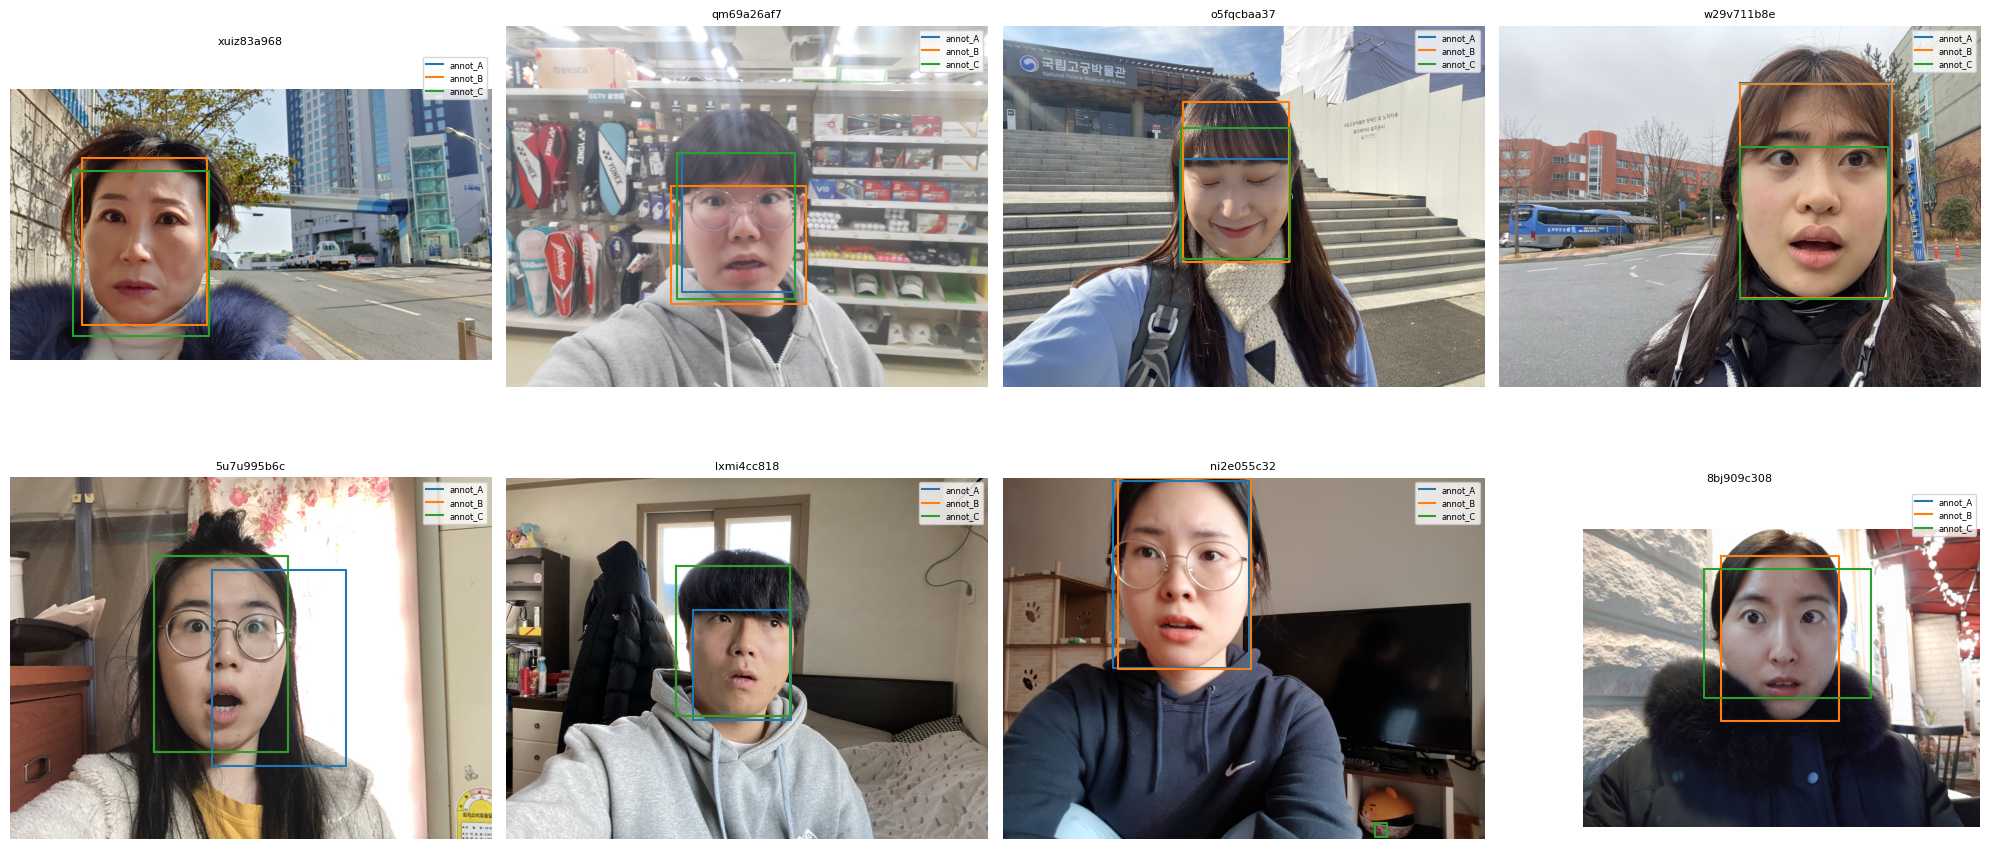

In [30]:
# outlier 시각화

# 이미지,박스 시각화 함수 정의
def visualize_boxes(data, image_dir):
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.ravel()

    for idx, item in enumerate(data):
        filename = item['filename']
        image_path = os.path.join(image_dir, filename)

        if not os.path.exists(image_path):
            print(f"Image {filename} not found in directory {image_dir}.")
            continue

        # Load image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axes[idx].imshow(image) 
        axes[idx].axis('off')

        # Plot boxes from annotations
        for annot_key in ['annot_A', 'annot_B', 'annot_C']:
            if annot_key in item:
                box = item[annot_key]['boxes']
                x = [box['minX'], box['maxX'], box['maxX'], box['minX'], box['minX']]
                y = [box['minY'], box['minY'], box['maxY'], box['maxY'], box['minY']]
                axes[idx].plot(x, y, label=annot_key)

        axes[idx].set_title(filename[:10], fontsize=8)
        axes[idx].legend(fontsize=6)
       
    # Hide unused subplots
    for i in range(len(data), 8):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()
    
visualize_boxes(outlier_json_panic, panic_img_path)

In [31]:
# outlier 데이터 좌표 출력

def format_boxes(box):
    return {key: round(value, 2) for key, value in box.items()}

def print_outlier_coordinates(outlier_data):
    for i, entry in enumerate(outlier_data):
        print(f"Outlier {i+1}:")
        print(f"Filename: {entry['filename']}")
        print(f"  annot_A: {format_boxes(entry['annot_A']['boxes'])}")
        print(f"  annot_B: {format_boxes(entry['annot_B']['boxes'])}")
        print(f"  annot_C: {format_boxes(entry['annot_C']['boxes'])}")
        print("-" * 50)

print_outlier_coordinates(outlier_json_panic)

Outlier 1:
Filename: xuiz83a96877b841898d16f32a9276e7a8d779d8d68f458e2816e296d6558w6em.jpg
  annot_A: {'maxX': 0, 'maxY': -146.85, 'minX': 0, 'minY': -146.85}
  annot_B: {'maxX': 1313.98, 'maxY': 1572.79, 'minX': 482.65, 'minY': 459.74}
  annot_C: {'maxX': 1326.96, 'maxY': 1646.84, 'minX': 417.85, 'minY': 545.1}
--------------------------------------------------
Outlier 2:
Filename: qm69a26af73232c7cde3b4233338b325218c82eea2e2cc80563e264beccd5m5on.jpg
  annot_A: {'maxX': 2765.61, 'maxY': 2551.82, 'minX': 1679.9, 'minY': 1222.02}
  annot_B: {'maxX': 2873.13, 'maxY': 2666.79, 'minX': 1579.06, 'minY': 1529.98}
  annot_C: {'maxX': 2765.39, 'maxY': 2620.15, 'minX': 1632.63, 'minY': 1222.28}
--------------------------------------------------
Outlier 3:
Filename: o5fqcbaa37a381ba1930720956a1611910f2c1aaa7f937afdf0abe43a3ef5ynti.jpg
  annot_A: {'maxX': 2404.47, 'maxY': 1975.13, 'minX': 1490.06, 'minY': 1114.67}
  annot_B: {'maxX': 2396.05, 'maxY': 1977.3, 'minX': 1508.95, 'minY': 640.52}
  ann